In [ ]:
# ECE 592 Project 4
# Vivek Onkarnath Rathi - 200256752
# Marc Foster - 200158695

In [232]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from tqdm import tqdm
np.random.seed(1040)
from collections import Counter

In [233]:
# KMeans Class
# Finds centroids
# Calculates distance (euclidean)
# Uses centroid with minimum distance
# Performs above steps iteratively

class KMeans:
    # constructor
    def __init__(self, tolerance=0.001, max_iter=100, random=True):
#         self.k = k
        self.tol = tolerance
        self.max_iter = max_iter
        self.random = random
    
    # fit the K-Means clustering
    def fit(self,data):
        # centroids dictionary
        self.centroids = {}
        
        # length of data
        self.length = len(data)
        
        # assign centroids - Use first K or random
        for i in range(self.k):
            if self.random:
                r = np.random.randint(low=0, high=self.length-1)
                self.centroids[i] = data[r]
            else:
                self.centroids[i] = data[i]
        
        # classify clusters
        for i in tqdm(range(self.max_iter)):
            # create classifcation dictionary
            self.classifications = {}
            
            # create list to store all possible vectors belonging to classification
            for i in range(self.k):
                self.classifications[i] = []
            
            # classify each vector into the cluster
            for vector in data:
                distances = [np.linalg.norm(vector-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(vector)
            
            # create shallow copy of centroids
            prev_centroids = dict(self.centroids)
            
            # update centroids with average of all vectors in cluster
            for classification in self.classifications:
                self.centroids[classification] = np.average(self.classifications[classification],axis=0)
            
            
            # optimiaztion to check centroids are closers or not
            optimized = True

            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
#                     print(np.sum((current_centroid-original_centroid)/original_centroid*100.0))
                    optimized = False

            if optimized:
                break
    
    # predict the labels for all data
    def predict(self,data):
        classification = []
        for d in data:
            distances = [np.linalg.norm(d-self.centroids[centroid]) for centroid in self.centroids]
            classification.append(distances.index(min(distances)))
        return (np.array(classification)).flatten(), np.array([self.centroids[c] for c in self.centroids])
    
    # k-means algorithm giving clusters and centroids
    def kmeans_cluster(self,data,clusters):
        self.k = clusters
        if clusters > len(data):
            raise Exception("Sorry, clusters more than samples; Bad Math!")
        else:
            self.fit(data)
        return self.predict(data)
        

In [246]:
class Image(KMeans):
    #constructor
    def __init__(self,image,patch_size,clusters):
        super().__init__()
        self.image = image
        self.p_size = patch_size
        self.clusters = clusters
        self.no_patches = image.shape[0]**2//patch_size**2
    
    #create patches
    def create_patch(self):
        r,c = self.image.shape[0], self.image.shape[1]
        self.patches = [self.image[i:i+self.p_size,j:j+self.p_size] for i in range(0,r,self.p_size) for j in range(0,c,self.p_size)]
    
    #create stack
    def stack_patch(self,axis=0):
        # axis 0 : stack row wise, axis 1: stack column wise
        self.patches = np.array(self.patches)
        if axis:
            self.patches = self.patches.reshape(-1,self.p_size**2).T
        else:
            self.patches = self.patches.reshape(-1,self.p_size**2)
    
    # create clusters
    def create_clusters(self):
        self.stack_patch()
        self.patches = np.float32(self.patches)
        self.labels, self.centers = self.kmeans_cluster(self.patches,self.clusters)
    
    # update patches with centers
    def update_patches(self):
        for i,p in enumerate(self.patches):
            self.patches[i] = self.centers[self.labels[i]]
    
    # decode to image
    def create_image(self):
        self.img = np.zeros(self.image.shape)
        r,c = self.image.shape[0],self.image.shape[1]
        K = np.array([p.reshape(self.p_size,self.p_size) for p in self.patches])
        k = 0
        for i in range(0,r,self.p_size):
            for j in range(0,c,self.p_size):
                self.img[i:i+self.p_size,j:j+self.p_size] = K[k]
                k+=1
    
    # get distortion
    def distortion(self):
        D = np.float32(self.image) - np.float32(self.img)
        D = np.sum(np.square(D))
        D = D / (self.image.shape[0]*self.image.shape[1])
        self.D = np.round(D,2)
        bits = np.log2(self.clusters)
        self.RD = np.round(bits/(self.p_size**2),5)
    
    # get lossy compression
    def lossy_compression(self):
        self.create_patch() # create patches
        self.create_clusters() # stack patches and create clusters
        self.update_patches() # update patches
        self.create_image() # create new patched image
        self.distortion() # get distortion metric
        
        return self.img,self.D,self.RD
    
    # get entropy for compression
    def better_compression(self):
#         print(self.length)
        count = Counter((self.labels))
        for c in count:
            count[c]/=self.length
        H = [count[c]*np.log2(count[c]) for c in count]
        return np.round((sum(H)*-1)/self.p_size**2,4)
        
        
    

Loaded Input Image Shape: (512, 512)


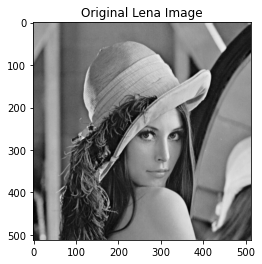

In [239]:
#1 - loading image
print("Loaded Input Image Shape:", img.shape)
img = cv2.imread('lenna.png',0)
plt.imshow(img,cmap='gray')
plt.title('Original Lena Image')
plt.show()

Random Image Patch/Part
Random Image Shape: (128, 128)


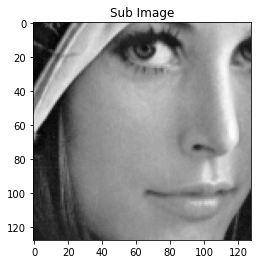

In [240]:
#2 - Clustering and vector quantization
print("Random Image Patch/Part")
sub_img = img[250:250+128,200:200+128]
print("Random Image Shape:", sub_img.shape)
plt.imshow(sub_img,cmap='gray')
plt.title('Sub Image')
plt.show()

In [241]:
compression = Image(sub_img,2,16) # compression object for 16 clusters
c_img,c_D,c_RD = compression.lossy_compression() # get compressed image

 39%|███████████████████████████████▌                                                 | 39/100 [00:33<00:51,  1.18it/s]


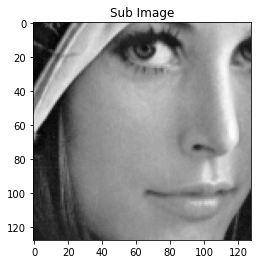

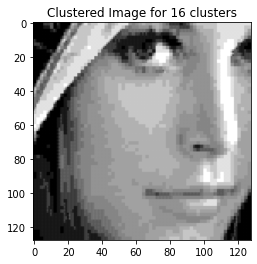

Distortion = 46.44
Rate Distortion = 1.0


In [258]:
plt.figure()
plt.imshow(sub_img,cmap='gray')
plt.title('Sub Image')
plt.show()

plt.figure()
plt.imshow(c_img,cmap='gray')
plt.title('Clustered Image for 16 clusters')
plt.show()

print("Distortion = {}".format(c_D))
print("Rate Distortion = {}".format(c_RD))

In [253]:
compression = Image(sub_img,2,64) # 64 clusters
_,d,rd = compression.lossy_compression()

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]<ipython-input-233-762be540784e>:54: RuntimeWarning: invalid value encountered in greater
  if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [04:27<00:43,  3.11s/it]


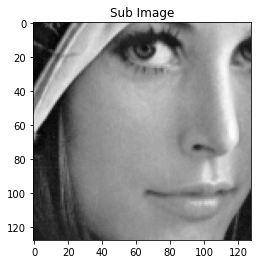

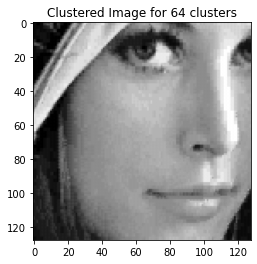

Distortion = 19.8
Rate Distortion = 1.5


In [259]:
plt.figure()
plt.imshow(sub_img,cmap='gray')
plt.title('Sub Image')
plt.show()

plt.figure()
plt.imshow(_,cmap='gray')
plt.title('Clustered Image for 64 clusters')
plt.show()

print("Distortion = {}".format(d))
print("Rate Distortion = {}".format(rd))

 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:52<00:28,  1.25it/s]


R =  [0.2, 0.4, 0.6, 0.8, 1]
D =  [1672.94, 554.37, 122.1, 70.64, 44.86]


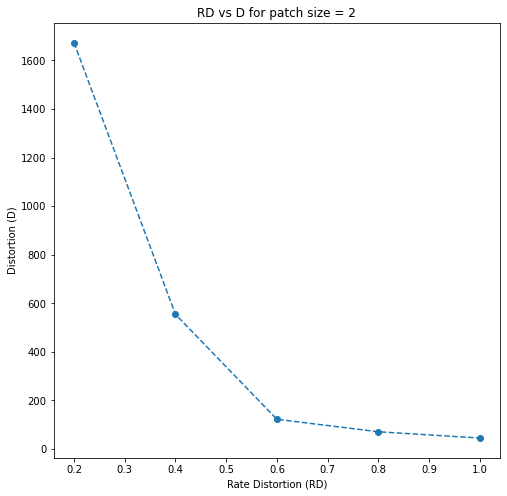

In [249]:
#3 - Rate vs. distortion
def part3(R,patch_size):
    K = [int(2**(r*patch_size**2)) for r in R]
    D = []
    for k in K:
        compression = Image(sub_img,patch_size,k)
        if compression.no_patches > k:
            _,d,rd = compression.lossy_compression()
            D.append(d)
    return D

R = [0.2,0.4,0.6,0.8,1]
D2 = part3(R,2)

print("R = ",R[:len(D2)])
print("D = ",D2)

plt.figure(figsize=(8,8))
plt.plot(R[:len(D2)],D2,'o--')
plt.xlabel("Rate Distortion (RD)")
plt.ylabel("Distortion (D)")
plt.title("RD vs D for patch size = 2")
plt.show()

In [ ]:
# Discussion
# 1. From above plot as Rate Distortion Increases, Distortion Decreases

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]<ipython-input-233-762be540784e>:54: RuntimeWarning: invalid value encountered in greater
  if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
  4%|███▎                                                                              | 4/100 [00:49<19:49, 12.39s/it]


R =  [0.2, 0.4, 0.6]
D =  [144.16, 37.03, 9.61]


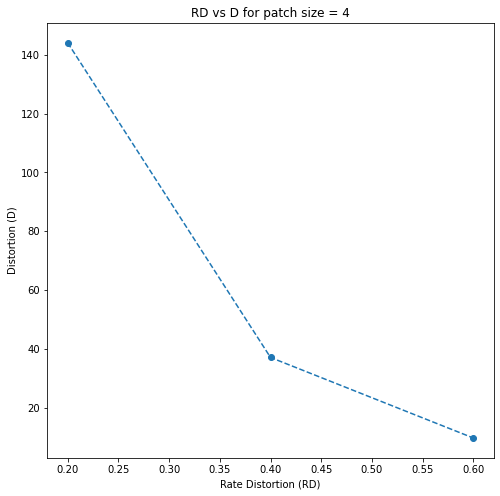

In [250]:
#4 - Patch size : part 3 has patch size = 2*2, here we use patch size = 4*4
R = [0.2,0.4,0.6,0.8,1]
D4 = part3(R,4)
print("R = ",R[:len(D4)])
print("D = ",D4)
plt.figure(figsize=(8,8))
plt.plot(R[:len(D4)],D4,'o--')
plt.xlabel("Rate Distortion (RD)")
plt.ylabel("Distortion (D)")
plt.title("RD vs D for patch size = 4")
plt.show()

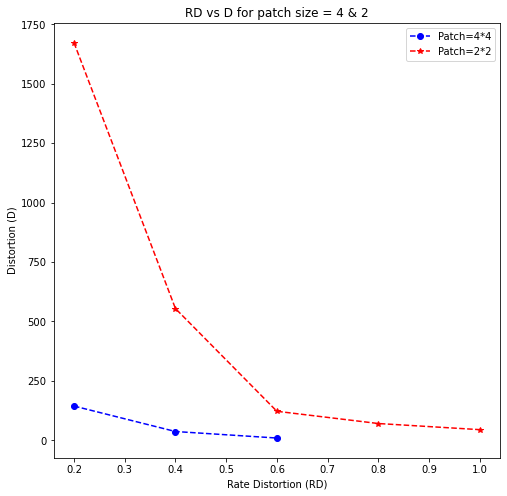

In [251]:
plt.figure(figsize=(8,8))
plt.plot(R[:len(D4)],D4,'bo--',label="Patch=4*4")
plt.plot(R[:len(D2)],D2,'r*--',label="Patch=2*2")
plt.legend()
plt.xlabel("Rate Distortion (RD)")
plt.ylabel("Distortion (D)")
plt.title("RD vs D for patch size = 4 & 2")
plt.show()

In [ ]:
# Discussion:
# 1. As patch size increases, for given rate distortion the no. of clusters increase,
#    thus, as clusters increase distortion decreases; blue graph is much similar to
#    last 3 samples in red which implies comparable no. of clusters used.
    

  1%|▊                                                                                 | 1/100 [00:00<00:15,  6.36it/s]

4096


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

4096


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

4096


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

4096


 19%|███████████████▍                                                                 | 19/100 [00:16<01:12,  1.12it/s]


4096
Entropy =  [-0.0, 0.3656, 0.4902, 0.753, 0.8912]


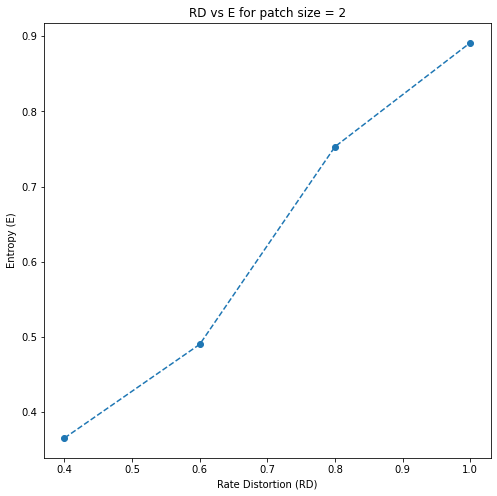

In [252]:
#5 - Better compression
def part5(R,patch_size):
    K = [int(2**(r*patch_size**2)) for r in R]
    E = []
    for k in K:
        compression = Image(sub_img,patch_size,k)
        _,_,_ = compression.lossy_compression()
        E.append(compression.better_compression())
    return E

E = part5(R,2)
print("Entropy = ",E)
plt.figure(figsize=(8,8))
plt.plot(R[1:],E[1:],'o--')
plt.xlabel("Rate Distortion (RD)")
plt.ylabel("Entropy (E)")
plt.title("RD vs E for patch size = 2")
plt.show()

In [ ]:
# Discussion -
# 1. It is clear that encoding the bits using entropy saves the overall no. of bits.
# 2. Here, for 16 clusters, 11% reduction in coding rate can be found.